### Getting Started

Dataset comes from Kaggle repository [link](https://www.kaggle.com/datasets/joebeachcapital/30000-spotify-songs/data).  Almost 30,000 Songs from the Spotify API. See the readme file for a formatted data dictionary table.



### Problem 2: Read in the Data

Use pandas to read in the dataset `spotify_songs.csv` and assign to a meaningful variable name.

In [116]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

In [117]:
df = pd.read_csv('data/spotify_songs.csv')

In [118]:
df.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


### Problem 3: Understanding the Features



In [119]:
# Problem 3: Understanding the Features
# Let's examine the data for missing values
print("\nMissing values:")
print(df.isnull().sum())
print("\nUnique values in each categorical column:")
categorical_cols = df.select_dtypes(include=['object']).columns


Missing values:
track_id                    0
track_name                  5
track_artist                5
track_popularity            0
track_album_id              0
track_album_name            5
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64

Unique values in each categorical column:


### Problem 4: Understanding the Task


**Objective is to recommend songs to users**

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  
 14  loudne

# **Methods**

In [121]:
#Convert date to year
def convert_to_year(date_value):
    """
    Convert date or year to year format
    """
    if pd.isna(date_value):
        return date_value  # Keep NaN as is

    # Convert to string to handle different input types
    date_str = str(date_value).strip()

    # If it's already just a year (4 digits)
    if date_str.isdigit() and len(date_str) == 4:
        return int(date_str)

    # Try to parse as date and extract year
    try:
        # Handle various date formats
        parsed_date = pd.to_datetime(date_str, errors='coerce')
        if not pd.isna(parsed_date):
            return parsed_date.year
    except:
        pass

    # If parsing fails, try to extract 4-digit year from string
    import re
    year_match = re.search(r'\b(19|20)\d{2}\b', date_str)
    if year_match:
        return int(year_match.group())

    # If all fails, return original value or NaN
    return np.nan

# **Preprocessing**

In [122]:
#Remove rows where track_name, track_artist,track_album_name is na

df.dropna(subset=['track_name', 'track_artist', 'track_album_name'], inplace=True)

df.shape

(32828, 23)

In [123]:
#Rename columns for readability

df.rename(columns={'playlist_genre': 'genre', 'playlist_subgenre': 'subgenre'}, inplace=True)

In [124]:
# Conver track_album_release_date to year
df['year'] = df['track_album_release_date'].apply(convert_to_year)

#Drop track_album_release_date
df.drop(columns=['track_album_release_date'], inplace=True)

**Observe track count**

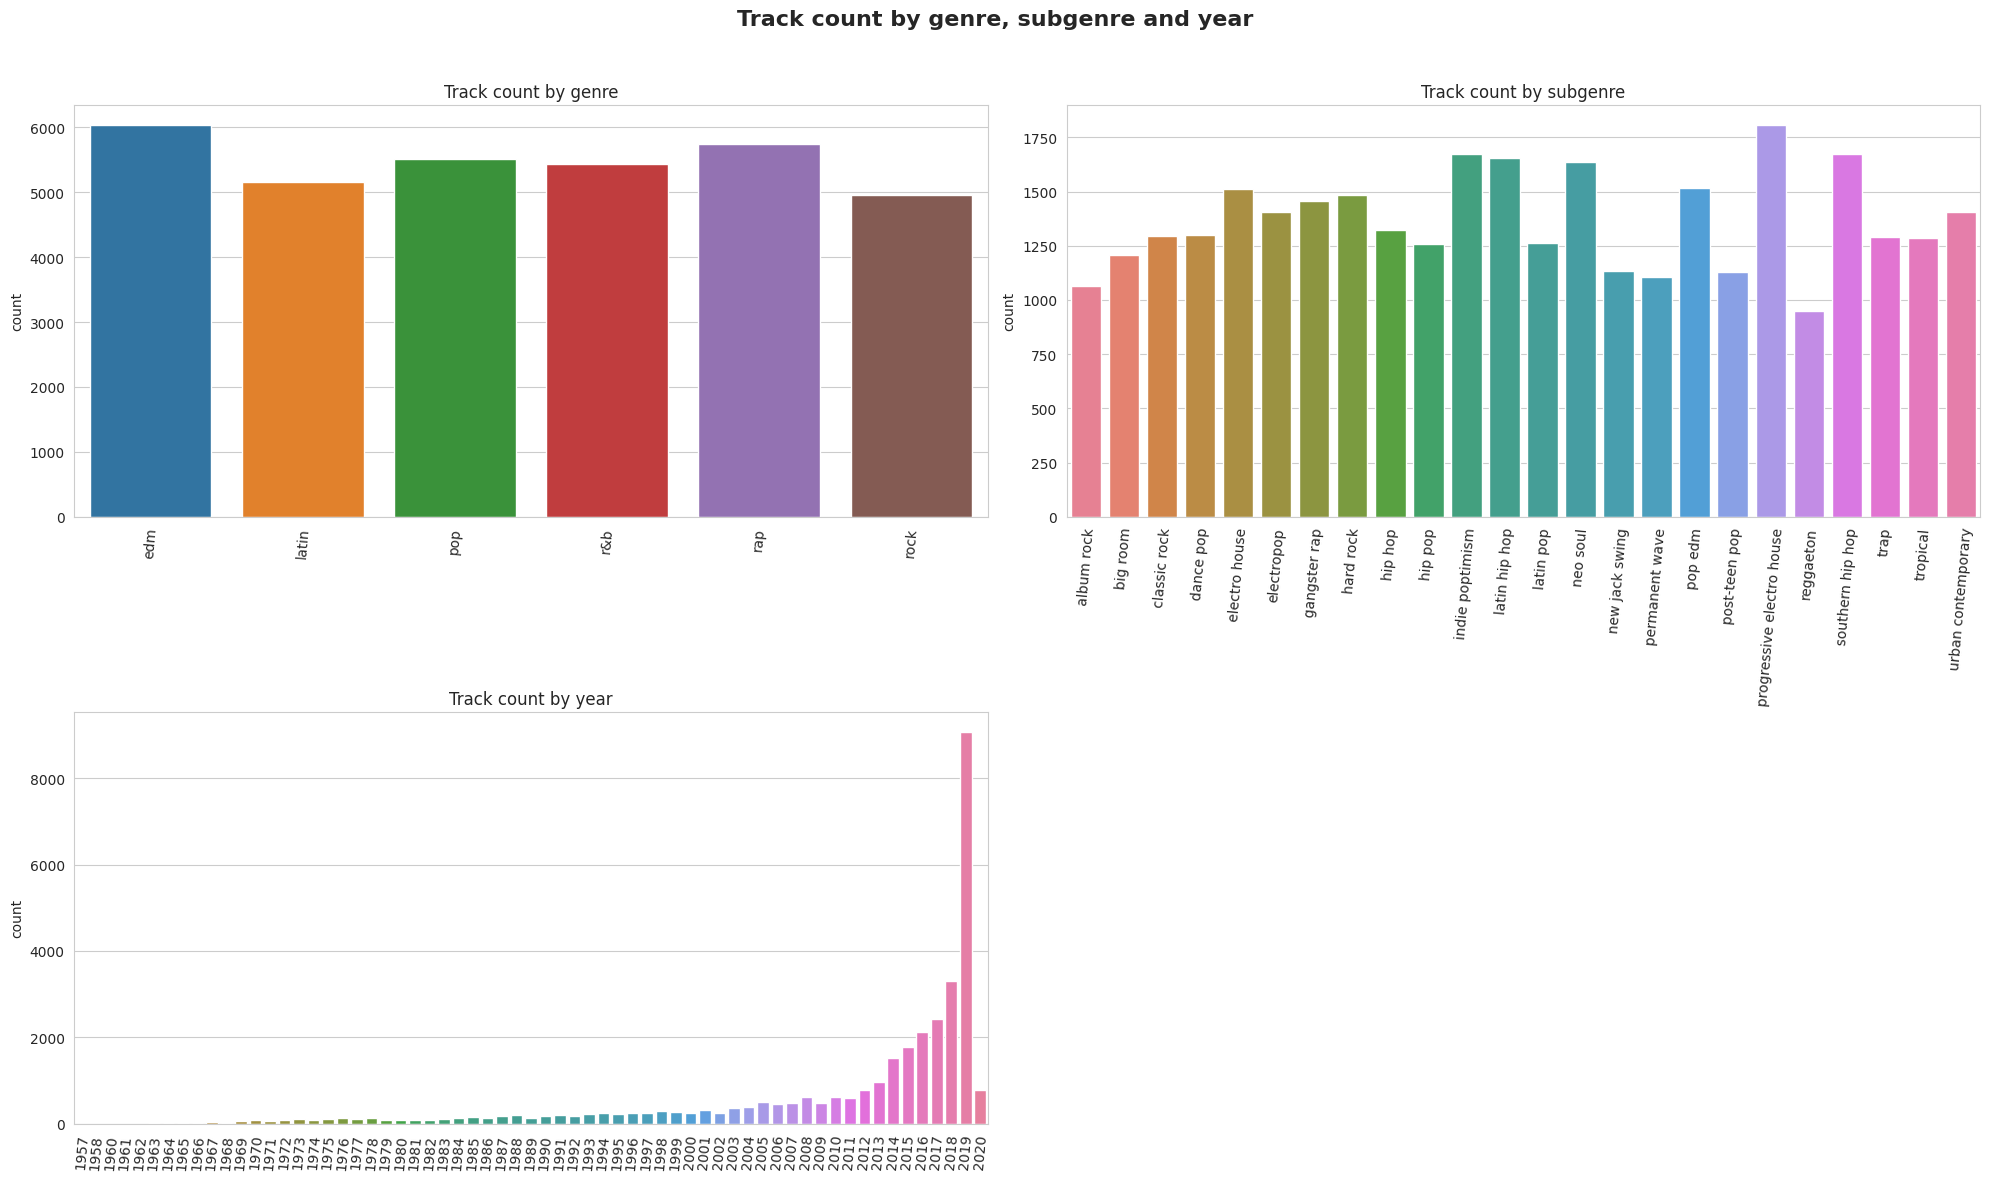

In [125]:
categorical_columns = ['genre','subgenre','year']
clean_data = df.dropna(subset=categorical_columns).copy()

# Calculate subplot grid
n_cols = 2 # Number of columns in subplot grid
n_rows = int(np.ceil(len(categorical_columns) / n_cols))

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
fig.suptitle('Track count by genre, subgenre and year', fontsize=16, fontweight='bold')

# Flatten axes for easy iteration
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    clean_data[col] = clean_data[col].astype('category')

    # Plot on specific subplot
    sns.countplot(x=col, data=clean_data, hue=col, ax=axes[i], legend=False)
    axes[i].set_title(f'Track count by {col}', fontsize=12)
    axes[i].tick_params(axis='x', rotation=85)
    axes[i].set_xlabel('')

# Hide empty subplots if any
for j in range(len(categorical_columns), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(top=0.90)  # Add space between suptitle and subplots
plt.show()

**Observe popularity**

/tmp/ipython-input-1650530105.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_popularity.values, y=genre_popularity.index, palette='flare')


Text(0, 0.5, 'Playlist Genre')

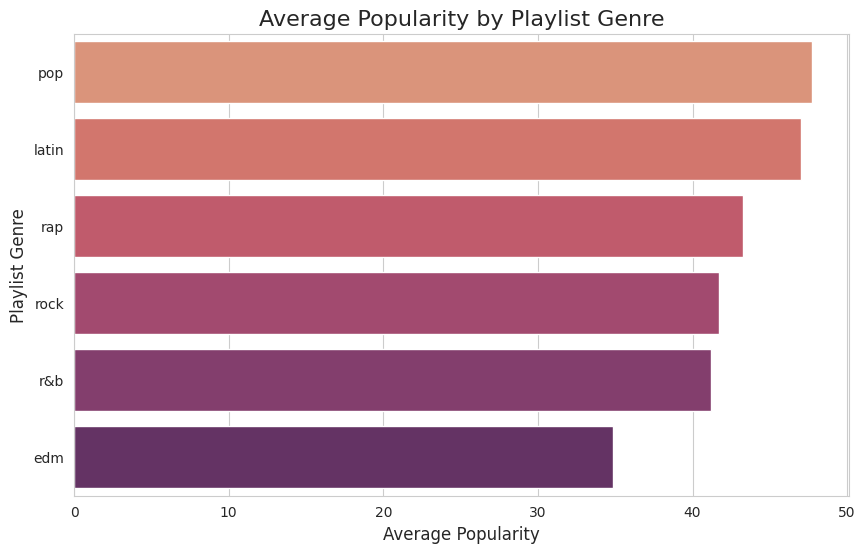

In [126]:
genre_popularity = df.groupby('genre')['track_popularity'].mean().sort_values(ascending=False)
subgenre_popularity = df.groupby('subgenre')['track_popularity'].mean().sort_values(ascending=False)

# Sns barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_popularity.values, y=genre_popularity.index, palette='flare')
plt.title('Average Popularity by Playlist Genre', fontsize=16)
plt.xlabel('Average Popularity', fontsize=12)
plt.ylabel('Playlist Genre', fontsize=12)

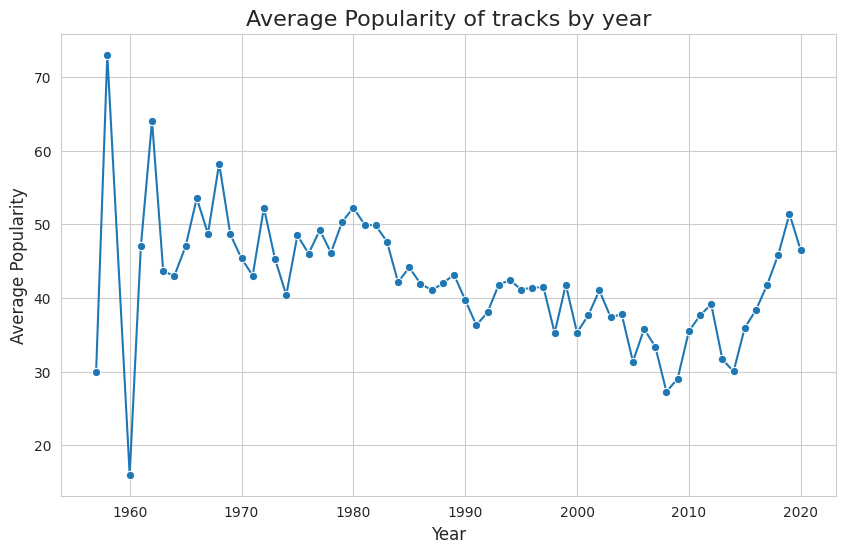

In [127]:
year_popularity = df.groupby('year')['track_popularity'].mean()

#Sns lineplot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.lineplot(x=year_popularity.index, y=year_popularity.values, marker='o')
plt.title('Average Popularity of tracks by year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Popularity', fontsize=12)

plt.show()

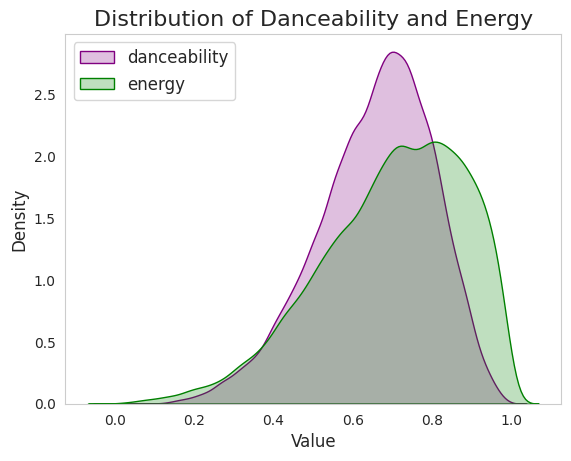

In [128]:
sns.kdeplot(data=df['danceability'],label='danceability',fill=True, color ='purple')
sns.kdeplot(data=df['energy'],label='energy',fill=True, color='green')
plt.title('Distribution of Danceability and Energy', fontsize=16)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=12)
plt.grid(False)
plt.show()

In [129]:
#Top 10 all time tracks by popluarity
top_10_unique_tracks = df.drop_duplicates('track_name').nlargest(10, 'track_popularity')[['track_name', 'track_popularity']].reset_index(drop=True)
print(top_10_unique_tracks)


                  track_name  track_popularity
0                       Tusa                98
1                   Memories                98
2            Blinding Lights                98
3                    The Box                98
4        everything i wanted                97
5            Don't Start Now                97
6                    Falling                97
7  RITMO (Bad Boys For Life)                96
8                    bad guy                95
9                      Yummy                95


In [130]:

#Top 10 all time artists by popluarity
top_10_artist = df.drop_duplicates('track_artist').nlargest(10, 'track_popularity')[['track_artist', 'track_popularity']].reset_index(drop=True)
print(top_10_artist)

          track_artist  track_popularity
0              KAROL G                98
1           The Weeknd                98
2          Roddy Ricch                98
3        Trevor Daniel                97
4  The Black Eyed Peas                96
5               Regard                94
6         Travis Scott                94
7            blackbear                94
8             Anuel AA                93
9               DaBaby                93
